In [1]:
import numpy as np
import pandas as pd
import datetime as dt

pd.set_option('display.max_rows', 16)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 9.0)
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

import gc

In [2]:
plt.rcParams['figure.figsize'] = (16.0, 9.0)

- [Data](#data)
  - [Risk free rate](#risk-free-rate)
  - [Beta](#beta)
  - [BM](#bm)
  - [Trading data](#trading-data)
    - [Monthly trading data](#monthly-trading-data)
    - [Momentum and reversal](#momentum-and-reversal)
- [Merge](#merge)
- [Monthly Factors](#monthly-factors)
  - [市场收益率](#市场收益率)
- [Daily factors](#daily-factors)


# Data

In [3]:
START = '2007-01-01'
END = '2023-03-31'
# Security Id
stk_info = DataAPI.SecIDGet(assetClass="E",pandas="1")
cond1 = (stk_info['exchangeCD'] == 'XSHE') | (stk_info['exchangeCD'] == 'XSHG')
cond2 = (stk_info['listStatusCD'] == 'L') | (stk_info['listStatusCD'] == 'DE')
cond3 = stk_info['transCurrCD']=='CNY'
stk_info = stk_info[cond1 & cond2 & cond3].copy()
stk_id = stk_info['secID']

## ST

In [4]:
st_df = DataAPI.SecSTGet(beginDate=START,endDate=END,secID=stk_id,field=['secID','tradeDate','STflg'],pandas="1")

In [5]:
st_df['tradeDate'] = pd.to_datetime(st_df['tradeDate'],format="%Y-%m-%d")

## Risk free rate

In [6]:
shibor_df = DataAPI.MktIborGet(secID="Shibor1M.IRCN",beginDate=START,endDate=END,field=['secID','tradeDate','rate'],pandas="1")
shibor_df['rate'] = shibor_df['rate']*0.01/12
shibor_df['tradeDate'] = pd.to_datetime(shibor_df['tradeDate'])
shibor_df.drop('secID',axis=1,inplace=True)
shibor_df.rename(columns={'rate':'rf'},inplace=True)
shibor_df['ym'] = shibor_df['tradeDate'].dt.to_period('M')
shibor_df.sort_values('tradeDate',inplace=True)
shibor_df_m = shibor_df.groupby('ym',as_index=False).last()
shibor_df_m.drop('tradeDate',axis=1,inplace=True)
shibor_df_m

ym        rf
0    2007-01  0.002100
1    2007-02  0.002110
2    2007-03  0.002234
3    2007-04  0.002125
4    2007-05  0.002527
5    2007-06  0.002542
6    2007-07  0.002481
7    2007-08  0.002404
..       ...       ...
187  2022-08  0.001251
188  2022-09  0.001426
189  2022-10  0.001400
190  2022-11  0.001596
191  2022-12  0.001955
192  2023-01  0.001856
193  2023-02  0.001910
194  2023-03  0.001970

[195 rows x 2 columns]

## Beta

In [7]:
beta_df = pd.read_pickle('./data/beta_df.pkl')
beta_df['tradeDate'] = pd.to_datetime(beta_df['tradeDate'], format="%Y-%m-%d")
beta_df['ym'] = beta_df['tradeDate'].dt.to_period('M')
beta_df.drop(['Beta60','Beta120'],axis=1,inplace=True)
beta_df['Beta252'] = pd.to_numeric(beta_df['Beta252'])
# Winsorization
# up_q = 0.99999
# lower_q = 0.00001
# beta_df['Beta252_winsor'] = beta_df['Beta252'].clip(lower=beta_df['Beta252'].quantile(lower_q),upper=beta_df['Beta252'].quantile(up_q))
# Monthly
beta_df_m = beta_df.groupby(['secID','ym'],as_index=False)['Beta252'].last()
beta_df_m.rename(columns={'Beta252':'beta'},inplace=True)
beta_df_m

secID       ym    beta
0       000001.XSHE  2007-01  0.7949
1       000001.XSHE  2007-02  0.7880
2       000001.XSHE  2007-03  0.8512
3       000001.XSHE  2007-04  0.8642
4       000001.XSHE  2007-05  0.7715
5       000001.XSHE  2007-06  0.4614
6       000001.XSHE  2007-07  0.6423
7       000001.XSHE  2007-08  0.7722
...             ...      ...     ...
554352  689009.XSHG  2022-07  0.7987
554353  689009.XSHG  2022-08  0.8589
554354  689009.XSHG  2022-09  0.9106
554355  689009.XSHG  2022-10  0.7083
554356  689009.XSHG  2022-11  0.7363
554357  689009.XSHG  2022-12  0.6919
554358  689009.XSHG  2023-01  0.7379
554359  689009.XSHG  2023-02  0.7453

[554360 rows x 3 columns]

## BM

In [8]:
pb_df = pd.read_pickle('./data/pb_df.pkl')
pb_df['tradeDate'] = pd.to_datetime(pb_df['tradeDate'])
pb_df['PB'] = pd.to_numeric(pb_df['PB'])
pb_df['ym'] = pb_df['tradeDate'].dt.to_period('M')
pb_df.sort_values(['secID','tradeDate'],inplace=True)
pb_df = pb_df.groupby(['secID','ym'],as_index=False).last()
pb_df['bm'] = 1 / pb_df['PB']
pb_df.drop(['tradeDate','PB'],axis=1,inplace=True)
pb_df = pb_df[pb_df['bm'] >= 0]
pb_df

secID       ym        bm
0       000001.XSHE  2007-01  0.162639
1       000001.XSHE  2007-02  0.163321
2       000001.XSHE  2007-03  0.176236
3       000001.XSHE  2007-04  0.140732
4       000001.XSHE  2007-05  0.127291
5       000001.XSHE  2007-06  0.123739
6       000001.XSHE  2007-07  0.093992
7       000001.XSHE  2007-08  0.097085
...             ...      ...       ...
559224  689009.XSHG  2022-08  0.146757
559225  689009.XSHG  2022-09  0.168319
559226  689009.XSHG  2022-10  0.209701
559227  689009.XSHG  2022-11  0.201033
559228  689009.XSHG  2022-12  0.220085
559229  689009.XSHG  2023-01  0.201772
559230  689009.XSHG  2023-02  0.202930
559231  689009.XSHG  2023-03  0.193716

[551945 rows x 3 columns]

## Trading data

In [9]:
# %%time
# # About 8 mins
# # # 从优矿下载股票信息，时间较长。由于优矿的限制，每次下载3年的数据

# stk_dict = {}
# begin_ = dt.datetime.strptime(START, '%Y-%m-%d').year
# end_ = dt.datetime.strptime(START, '%Y-%m-%d').year+3
# field = ['secID','tradeDate','preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
# while begin_ <= 2023:
#     if begin_ == 2023:
#         yesterday = dt.datetime.today() - dt.timedelta(days=1)
#         yesterday.strftime('%Y%m%d')
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                      beginDate=f'{begin_}0101',
#                                                      endDate=yesterday,
#                                                      field=field,pandas="1")
#     else:
#         stk_dict[begin_] = DataAPI.MktEqudAdjAfGet(secID=stk_id,
#                                                          beginDate=f'{begin_}0101',
#                                                          endDate=f'{end_}1231',
#                                                          field=field,pandas="1")
#     begin_ = end_ + 1
#     end_ = begin_ + 3
    
# for i in range(len(stk_dict)):
#     stk_df = pd.DataFrame(np.vstack([_df for _df in stk_dict.values()]),columns=field)
    
# stk_df.to_pickle('./data/stk_df.pkl')

In [16]:
# stk_df = pd.read_pickle('./data/stk_df.pkl')
# stk_df['tradeDate'] = pd.to_datetime(stk_df['tradeDate'], format='%Y-%m-%d')
# stk_df.sort_values(['secID','tradeDate'],inplace=True)
# # drop ST stocks
# print(stk_df.shape)
# stk_df = pd.merge(stk_df, st_df, on=['secID','tradeDate'],how='left')
# stk_df = stk_df[stk_df['STflg'].isna()].copy()
# stk_df.drop('STflg',axis=1,inplace=True)
# print(stk_df.shape)

(11220557, 7)
(10702693, 7)


In [17]:
# num_cols = ['preClosePrice','closePrice','negMarketValue','turnoverValue','turnoverRate']
# for col in num_cols:
#     stk_df[col] = pd.to_numeric(stk_df[col])

In [18]:
# # # If the trading days are required to be consecutive, fill missing days first. This could possibly produce a much larger df when using 
# ## daily data, and if the missing dates are a lot for some securities

# def fill_missing(df, full_dates, id_col='secID', date_col='tradeDate'):
#     """
#     This function fills the missing dates for stocks.
#     Parameters:
#         df: The dataframe. Could be a sub-dataframe created by "groupby".
#             The dataframe must be sorted on the "date_col".
#         full_dates: the unique dates covering all securities in the full dataframe. 
#                     Need to be sorted.
#         id_col: the security id.
#         date_col: the dates column for the security
#     Returns:
#         A dataframe with the missing dates filled with NA.
#     """
#     stk_id = df[id_col].unique()
#     # Newer version of pandas will allow comparison between "Timestamp" and "datetime64"
# #     date_start = np.where(full_dates == df[date_col].min())[0][0] 
# #     date_end = np.where(full_dates == df[date_col].max())[0][0]
#     date_start = np.where(full_dates == df[date_col].min().to_datetime64())[0][0] 
#     date_end = np.where(full_dates == df[date_col].max().to_datetime64())[0][0]
#     dates = full_dates[date_start:date_end+1]
#     idx = pd.MultiIndex.from_product([stk_id,dates],
#                                      names=(id_col,date_col))
#     df = df.set_index([id_col,date_col]).reindex(idx).reset_index()
#     return df

In [19]:
# full_dates = np.sort(stk_df['tradeDate'].unique())

In [20]:
# %%time
# stk_df = stk_df.groupby('secID').apply(fill_missing, full_dates=full_dates)

CPU times: user 49.8 s, sys: 1.28 s, total: 51.1 s
Wall time: 51.1 s


In [21]:
# stk_df.reset_index(drop=True, inplace=True)

# stk_df['ret_daily'] = stk_df['closePrice'] / stk_df['preClosePrice'] - 1
# stk_df['illiq_daily'] = abs(stk_df['ret_daily'].values) / stk_df['turnoverValue'].values
# stk_df.loc[np.isinf(stk_df['illiq_daily']),'illiq_daily'] = np.nan
# stk_df['ym'] = stk_df['tradeDate'].dt.to_period('M')

# stk_df.to_pickle('./data/stk_df_filled.pkl')

In [24]:
stk_df = pd.read_pickle('./data/stk_df_filled.pkl')

In [25]:
stk_df

secID  tradeDate  preClosePrice  closePrice  negMarketValue  \
0         000001.XSHE 2007-06-20        824.193     987.007    4.835036e+10   
1         000001.XSHE 2007-06-21        987.007    1085.740    5.318694e+10   
2         000001.XSHE 2007-06-22       1085.740    1120.233    5.487665e+10   
3         000001.XSHE 2007-06-25       1120.233    1113.904    5.456661e+10   
4         000001.XSHE 2007-06-26       1113.904    1113.904    5.456661e+10   
5         000001.XSHE 2007-06-27       1113.904    1019.602    4.994705e+10   
6         000001.XSHE 2007-06-28       1019.602     953.780    4.672266e+10   
7         000001.XSHE 2007-06-29        953.780     870.870    4.266117e+10   
...               ...        ...            ...         ...             ...   
10996475  689009.XSHG 2023-03-01         33.000      33.540    1.716242e+10   
10996476  689009.XSHG 2023-03-02         33.540      34.540    1.767412e+10   
10996477  689009.XSHG 2023-03-03         34.540      34.570    1.768947e+10   
10996478  689009.XSHG 2023-03-06         34.570      33.890    1.734151e+10   
10996479  689009.XSHG 2023-03-07         33.890      33.370    1.707543e+10   
10996480  689009.XSHG 2023-03-08         33.370      34.080    1.743874e+10   
10996481  689009.XSHG 2023-03-09         34.080      33.410    1.709590e+10   
10996482  689009.XSHG 2023-03-10         33.410      32.610    1.668654e+10   

          turnoverValue  turnoverRate  ret_daily   illiq_daily       ym  
0          4.182345e+09        0.0840   0.197544  4.723272e-11  2007-06  
1          2.285485e+09        0.0440   0.100033  4.376871e-11  2007-06  
2          2.761567e+09        0.0510   0.031769  1.150402e-11  2007-06  
3          2.324186e+09        0.0426  -0.005650  2.430837e-12  2007-06  
4          0.000000e+00        0.0000   0.000000           NaN  2007-06  
5          2.446556e+09        0.0489  -0.084659  3.460334e-11  2007-06  
6          1.617434e+09        0.0336  -0.064557  3.991295e-11  2007-06  
7          1.410758e+09        0.0316  -0.086928  6.161781e-11  2007-06  
...                 ...           ...        ...           ...      ...  
10996475   1.944676e+08        0.0113   0.016364  8.414582e-11  2023-03  
10996476   2.680590e+08        0.0152   0.029815  1.112261e-10  2023-03  
10996477   1.751267e+08        0.0099   0.000869  4.959600e-12  2023-03  
10996478   1.447322e+08        0.0083  -0.019670  1.359078e-10  2023-03  
10996479   1.540738e+08        0.0089  -0.015344  9.958710e-11  2023-03  
10996480   1.229896e+08        0.0071   0.021277  1.729950e-10  2023-03  
10996481   1.240722e+08        0.0072  -0.019660  1.584531e-10  2023-03  
10996482   1.129391e+08        0.0068  -0.023945  2.120162e-10  2023-03  

[10996483 rows x 10 columns]

### Monthly trading data

In [26]:
stk_df_m = stk_df.groupby(['secID','ym'],as_index=False).last()
stk_df_m['ret'] = stk_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1)
stk_df_m['size'] = np.log(stk_df_m['negMarketValue'])
stk_df_m.drop(['tradeDate','preClosePrice'],axis=1,inplace=True)
stk_df_m = pd.merge(stk_df_m, shibor_df_m, on='ym')
stk_df_m['exret'] = stk_df_m['ret'] - stk_df_m['rf']
stk_df_m.sort_values(['secID','ym'],inplace=True)
stk_df_m.rename(columns={'negMarketValue':'mktcap'},inplace=True)
stk_df_m

secID       ym  closePrice        mktcap  turnoverValue  \
0       000001.XSHE  2007-06     870.870  4.266117e+10   1.410758e+09   
1293    000001.XSHE  2007-07    1146.498  5.616330e+10   1.479466e+09   
2595    000001.XSHE  2007-08    1202.510  5.890714e+10   6.552881e+08   
3922    000001.XSHE  2007-09    1265.167  6.197651e+10   1.408136e+09   
5264    000001.XSHE  2007-10    1520.542  7.448652e+10   1.440425e+09   
6612    000001.XSHE  2007-11    1141.751  5.593078e+10   5.452159e+08   
7976    000001.XSHE  2007-12    1221.497  6.574629e+10   1.019671e+09   
9362    000001.XSHE  2008-01    1053.778  5.850212e+10   5.328429e+08   
...             ...      ...         ...           ...            ...   
508954  689009.XSHG  2022-08      44.030  2.240616e+10   9.711262e+07   
513653  689009.XSHG  2022-09      38.310  1.949535e+10   6.560969e+07   
518374  689009.XSHG  2022-10      32.000  1.637440e+10   1.649592e+08   
523119  689009.XSHG  2022-11      33.380  1.708055e+10   9.351642e+07   
527891  689009.XSHG  2022-12      30.490  1.560173e+10   8.049526e+07   
532669  689009.XSHG  2023-01      33.190  1.698332e+10   1.626498e+08   
537461  689009.XSHG  2023-02      33.000  1.688610e+10   3.453544e+08   
542263  689009.XSHG  2023-03      32.610  1.668654e+10   1.129391e+08   

        turnoverRate  ret_daily   illiq_daily       ret       size        rf  \
0             0.0316  -0.086928  6.161781e-11       NaN  24.476555  0.002542   
1293          0.0270   0.059356  4.012016e-11  0.316497  24.751529  0.002481   
2595          0.0112   0.007958  1.214425e-11  0.048855  24.799228  0.002404   
3922          0.0228   0.030147  2.140927e-11  0.052105  24.850021  0.002621   
5264          0.0200   0.065410  4.541049e-11  0.201851  25.033884  0.003095   
6612          0.0096  -0.026181  4.801976e-11 -0.249116  24.747381  0.003780   
7976          0.0154  -0.010256  1.005854e-11  0.069845  24.909069  0.003011   
9362          0.0089  -0.019146  3.593101e-11 -0.137306  24.792329  0.002949   
...              ...        ...           ...       ...        ...       ...   
508954        0.0043   0.004105  4.226951e-11 -0.112656  23.832602  0.001251   
513653        0.0034   0.008158  1.243398e-10 -0.129911  23.693442  0.001426   
518374        0.0100   0.000000  0.000000e+00 -0.164709  23.518985  0.001400   
523119        0.0054  -0.017368  1.857242e-10  0.043125  23.561206  0.001596   
527891        0.0051  -0.011349  1.409884e-10 -0.086579  23.470648  0.001955   
532669        0.0095   0.010966  6.741836e-11  0.088554  23.555498  0.001856   
537461        0.0206   0.042325  1.225544e-10 -0.005725  23.549757  0.001910   
542263        0.0068  -0.023945  2.120162e-10 -0.011818  23.537868  0.001970   

           exret  
0            NaN  
1293    0.314016  
2595    0.046451  
3922    0.049484  
5264    0.198756  
6612   -0.252896  
7976    0.066834  
9362   -0.140255  
...          ...  
508954 -0.113907  
513653 -0.131337  
518374 -0.166109  
523119  0.041529  
527891 -0.088534  
532669  0.086698  
537461 -0.007635  
542263 -0.013788  

[548447 rows x 12 columns]

In [27]:
stk_df_m[stk_df_m['secID'] == '000001.XSHE'].set_index('ym').loc['2010-01':'2010-12']
# 停牌的时间都填充为NaN。刚恢复交易的第一个月的月收益率也为NaN

secID  closePrice        mktcap  turnoverValue  turnoverRate  \
ym                                                                            
2010-01  000001.XSHE     895.357  6.345328e+10   5.284377e+08        0.0082   
2010-02  000001.XSHE     926.303  6.564637e+10   1.008966e+09        0.0154   
2010-03  000001.XSHE     957.248  6.783945e+10   7.105142e+08        0.0104   
2010-04  000001.XSHE     848.320  6.011979e+10   6.628292e+08        0.0111   
2010-05  000001.XSHE     722.475  5.120124e+10   4.806838e+08        0.0092   
2010-06  000001.XSHE     722.475  5.437499e+10   0.000000e+00        0.0000   
2010-07  000001.XSHE     722.475  5.437499e+10   0.000000e+00        0.0000   
2010-08  000001.XSHE     722.475  5.437499e+10   0.000000e+00        0.0000   
2010-09  000001.XSHE     669.249  5.036906e+10   0.000000e+00        0.0000   
2010-10  000001.XSHE     759.610  5.716982e+10   6.635094e+08        0.0115   
2010-11  000001.XSHE     676.263  5.089697e+10   4.642922e+08        0.0091   
2010-12  000001.XSHE     651.507  4.903361e+10   3.783178e+08        0.0078   

         ret_daily   illiq_daily       ret       size        rf     exret  
ym                                                                         
2010-01  -0.002299  4.350204e-12 -0.109561  24.873570  0.001511 -0.111072  
2010-02   0.013544  1.342342e-11  0.034563  24.907548  0.001547  0.033016  
2010-03  -0.019028  2.678085e-11  0.033407  24.940410  0.001450  0.031957  
2010-04   0.019336  2.917199e-11 -0.113793  24.819605  0.001464 -0.115256  
2010-05  -0.031527  6.558795e-11 -0.148346  24.659030  0.002081 -0.150427  
2010-06   0.000000  9.651729e-11  0.000000  24.719170  0.003236 -0.003236  
2010-07   0.000000           NaN  0.000000  24.719170  0.001798 -0.001798  
2010-08   0.000000           NaN  0.000000  24.719170  0.002369 -0.002369  
2010-09   0.000000  7.082247e-12 -0.073672  24.642643  0.002922 -0.076594  
2010-10  -0.019178  2.890457e-11  0.135019  24.769292  0.002214  0.132805  
2010-11  -0.019737  4.250943e-11 -0.109723  24.653069  0.003092 -0.112815  
2010-12   0.007659  2.024503e-11 -0.036607  24.615772  0.005141 -0.041748

### Momentum and reversal

#### Using unfilled data

In [28]:
stk_unfilled_df = pd.read_pickle('./data/stk_df.pkl')
stk_unfilled_df['tradeDate'] = pd.to_datetime(stk_unfilled_df['tradeDate'], format='%Y-%m-%d')
stk_unfilled_df['ym'] = stk_unfilled_df['tradeDate'].dt.to_period('M')
stk_unfilled_df.sort_values(['secID','tradeDate'],inplace=True)
# drop ST stocks
print(stk_unfilled_df.shape)
stk_unfilled_df = pd.merge(stk_unfilled_df, st_df, on=['secID','tradeDate'],how='left')
stk_unfilled_df = stk_unfilled_df[stk_unfilled_df['STflg'].isna()].copy()
stk_unfilled_df.drop('STflg',axis=1,inplace=True)
print(stk_unfilled_df.shape)
# Monthly
stk_unfilled_df_m = stk_unfilled_df.groupby(['secID','ym'],as_index=False).last()

(11220557, 8)
(10702693, 8)


In [29]:
stk_unfilled_df_m['ret_mom'] = stk_unfilled_df_m.groupby('secID')['closePrice'].apply(lambda x: x / x.shift() - 1) #这个ret_mom不用作后面ret的计算，后面仍保留monthly ret
stk_unfilled_df_m.sort_values(['secID','ym'],inplace=True)
stk_unfilled_df_m['1+ret_mom'] = stk_unfilled_df_m['ret_mom'] + 1

In [30]:
stk_unfilled_df_m['mom'] = stk_unfilled_df_m.groupby('secID').rolling(11,min_periods=9)['1+ret_mom'].apply(np.prod, raw=True).values - 1

In [31]:
stk_df_m = pd.merge(stk_df_m, stk_unfilled_df_m[['secID','ym','1+ret_mom']],on=['secID','ym'],how='left')
stk_df_m.loc[stk_df_m['1+ret_mom'].isna(),'1+ret_mom'] = 1 # 缺失位置填充为1，以便连乘。
stk_df_m['mom'] = stk_df_m.groupby('secID').rolling(11,min_periods=11)['1+ret_mom'].apply(np.prod, raw=True).values - 1 

In [32]:
stk_df_m['rev'] = stk_df_m['exret'].values
stk_df_m['ret'] = stk_df_m.groupby(['secID'])['ret'].shift(-1)
stk_df_m['rf'] = stk_df_m.groupby(['secID'])['rf'].shift(-1)
stk_df_m['exret'] = stk_df_m.groupby(['secID'])['exret'].shift(-1)
stk_df_m['ret_date'] = stk_df_m.groupby('secID')['ym'].shift(-1)

stk_df_m['mom'] = stk_df_m.groupby(['secID'])['mom'].shift()
stk_df_m['mom_date'] = stk_df_m.groupby('secID')['ym'].shift()

In [33]:
stk_df_m.drop(['ret_daily','turnoverValue','turnoverRate','illiq_daily','1+ret_mom'],axis=1,inplace=True)

In [34]:
stk_df_m

secID       ym  closePrice        mktcap       ret       size  \
0       000001.XSHE  2007-06     870.870  4.266117e+10  0.316497  24.476555   
1       000001.XSHE  2007-07    1146.498  5.616330e+10  0.048855  24.751529   
2       000001.XSHE  2007-08    1202.510  5.890714e+10  0.052105  24.799228   
3       000001.XSHE  2007-09    1265.167  6.197651e+10  0.201851  24.850021   
4       000001.XSHE  2007-10    1520.542  7.448652e+10 -0.249116  25.033884   
5       000001.XSHE  2007-11    1141.751  5.593078e+10  0.069845  24.747381   
6       000001.XSHE  2007-12    1221.497  6.574629e+10 -0.137306  24.909069   
7       000001.XSHE  2008-01    1053.778  5.850212e+10 -0.004504  24.792329   
...             ...      ...         ...           ...       ...        ...   
548439  689009.XSHG  2022-08      44.030  2.240616e+10 -0.129911  23.832602   
548440  689009.XSHG  2022-09      38.310  1.949535e+10 -0.164709  23.693442   
548441  689009.XSHG  2022-10      32.000  1.637440e+10  0.043125  23.518985   
548442  689009.XSHG  2022-11      33.380  1.708055e+10 -0.086579  23.561206   
548443  689009.XSHG  2022-12      30.490  1.560173e+10  0.088554  23.470648   
548444  689009.XSHG  2023-01      33.190  1.698332e+10 -0.005725  23.555498   
548445  689009.XSHG  2023-02      33.000  1.688610e+10 -0.011818  23.549757   
548446  689009.XSHG  2023-03      32.610  1.668654e+10       NaN  23.537868   

              rf     exret       mom       rev ret_date mom_date  
0       0.002481  0.314016       NaN       NaN  2007-07      NaT  
1       0.002404  0.046451       NaN  0.314016  2007-08  2007-06  
2       0.002621  0.049484       NaN  0.046451  2007-09  2007-07  
3       0.003095  0.198756       NaN  0.049484  2007-10  2007-08  
4       0.003780 -0.252896       NaN  0.198756  2007-11  2007-09  
5       0.003011  0.066834       NaN -0.252896  2007-12  2007-10  
6       0.002949 -0.140255       NaN  0.066834  2008-01  2007-11  
7       0.002946 -0.007450       NaN -0.140255  2008-02  2007-12  
...          ...       ...       ...       ...      ...      ...  
548439  0.001426 -0.131337 -0.338400 -0.113907  2022-09  2022-07  
548440  0.001400 -0.166109 -0.455748 -0.131337  2022-10  2022-08  
548441  0.001596  0.041529 -0.401406 -0.166109  2022-11  2022-09  
548442  0.001955 -0.088534 -0.474030  0.041529  2022-12  2022-10  
548443  0.001856  0.086698 -0.523619 -0.088534  2023-01  2022-11  
548444  0.001910 -0.007635 -0.498602  0.086698  2023-02  2022-12  
548445  0.001970 -0.013788 -0.418230 -0.007635  2023-03  2023-01  
548446       NaN       NaN -0.246403 -0.013788      NaT  2023-02  

[548447 rows x 12 columns]

# Merge

In [35]:
ret_df = pd.merge(stk_df_m[['secID','ret_date','ret','rf','exret','ym','mktcap','size','rev','mom_date','mom']], 
                  beta_df_m[['secID','ym','beta']], on=['secID','ym'], how='left')

In [36]:
ret_df

secID ret_date       ret        rf     exret       ym  \
0       000001.XSHE  2007-07  0.316497  0.002481  0.314016  2007-06   
1       000001.XSHE  2007-08  0.048855  0.002404  0.046451  2007-07   
2       000001.XSHE  2007-09  0.052105  0.002621  0.049484  2007-08   
3       000001.XSHE  2007-10  0.201851  0.003095  0.198756  2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003780 -0.252896  2007-10   
5       000001.XSHE  2007-12  0.069845  0.003011  0.066834  2007-11   
6       000001.XSHE  2008-01 -0.137306  0.002949 -0.140255  2007-12   
7       000001.XSHE  2008-02 -0.004504  0.002946 -0.007450  2008-01   
...             ...      ...       ...       ...       ...      ...   
548439  689009.XSHG  2022-09 -0.129911  0.001426 -0.131337  2022-08   
548440  689009.XSHG  2022-10 -0.164709  0.001400 -0.166109  2022-09   
548441  689009.XSHG  2022-11  0.043125  0.001596  0.041529  2022-10   
548442  689009.XSHG  2022-12 -0.086579  0.001955 -0.088534  2022-11   
548443  689009.XSHG  2023-01  0.088554  0.001856  0.086698  2022-12   
548444  689009.XSHG  2023-02 -0.005725  0.001910 -0.007635  2023-01   
548445  689009.XSHG  2023-03 -0.011818  0.001970 -0.013788  2023-02   
548446  689009.XSHG      NaT       NaN       NaN       NaN  2023-03   

              mktcap       size       rev mom_date       mom    beta  
0       4.266117e+10  24.476555       NaN      NaT       NaN  0.4614  
1       5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423  
2       5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722  
3       6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596  
4       7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988  
5       5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560  
6       6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468  
7       5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654  
...              ...        ...       ...      ...       ...     ...  
548439  2.240616e+10  23.832602 -0.113907  2022-07 -0.338400  0.8589  
548440  1.949535e+10  23.693442 -0.131337  2022-08 -0.455748  0.9106  
548441  1.637440e+10  23.518985 -0.166109  2022-09 -0.401406  0.7083  
548442  1.708055e+10  23.561206  0.041529  2022-10 -0.474030  0.7363  
548443  1.560173e+10  23.470648 -0.088534  2022-11 -0.523619  0.6919  
548444  1.698332e+10  23.555498  0.086698  2022-12 -0.498602  0.7379  
548445  1.688610e+10  23.549757 -0.007635  2023-01 -0.418230  0.7453  
548446  1.668654e+10  23.537868 -0.013788  2023-02 -0.246403     NaN  

[548447 rows x 12 columns]

In [37]:
ret_df = pd.merge(ret_df, pb_df, on=['secID','ym'],how='left')

In [38]:
ret_df

secID ret_date       ret        rf     exret       ym  \
0       000001.XSHE  2007-07  0.316497  0.002481  0.314016  2007-06   
1       000001.XSHE  2007-08  0.048855  0.002404  0.046451  2007-07   
2       000001.XSHE  2007-09  0.052105  0.002621  0.049484  2007-08   
3       000001.XSHE  2007-10  0.201851  0.003095  0.198756  2007-09   
4       000001.XSHE  2007-11 -0.249116  0.003780 -0.252896  2007-10   
5       000001.XSHE  2007-12  0.069845  0.003011  0.066834  2007-11   
6       000001.XSHE  2008-01 -0.137306  0.002949 -0.140255  2007-12   
7       000001.XSHE  2008-02 -0.004504  0.002946 -0.007450  2008-01   
...             ...      ...       ...       ...       ...      ...   
548439  689009.XSHG  2022-09 -0.129911  0.001426 -0.131337  2022-08   
548440  689009.XSHG  2022-10 -0.164709  0.001400 -0.166109  2022-09   
548441  689009.XSHG  2022-11  0.043125  0.001596  0.041529  2022-10   
548442  689009.XSHG  2022-12 -0.086579  0.001955 -0.088534  2022-11   
548443  689009.XSHG  2023-01  0.088554  0.001856  0.086698  2022-12   
548444  689009.XSHG  2023-02 -0.005725  0.001910 -0.007635  2023-01   
548445  689009.XSHG  2023-03 -0.011818  0.001970 -0.013788  2023-02   
548446  689009.XSHG      NaT       NaN       NaN       NaN  2023-03   

              mktcap       size       rev mom_date       mom    beta        bm  
0       4.266117e+10  24.476555       NaN      NaT       NaN  0.4614  0.123739  
1       5.616330e+10  24.751529  0.314016  2007-06       NaN  0.6423  0.093992  
2       5.890714e+10  24.799228  0.046451  2007-07       NaN  0.7722  0.097085  
3       6.197651e+10  24.850021  0.049484  2007-08       NaN  0.7596  0.092276  
4       7.448652e+10  25.033884  0.198756  2007-09       NaN  0.7988  0.083411  
5       5.593078e+10  24.747381 -0.252896  2007-10       NaN  0.9560  0.111084  
6       6.574629e+10  24.909069  0.066834  2007-11       NaN  0.9468  0.094476  
7       5.850212e+10  24.792329 -0.140255  2007-12       NaN  0.9654  0.109513  
...              ...        ...       ...      ...       ...     ...       ...  
548439  2.240616e+10  23.832602 -0.113907  2022-07 -0.338400  0.8589  0.146757  
548440  1.949535e+10  23.693442 -0.131337  2022-08 -0.455748  0.9106  0.168319  
548441  1.637440e+10  23.518985 -0.166109  2022-09 -0.401406  0.7083  0.209701  
548442  1.708055e+10  23.561206  0.041529  2022-10 -0.474030  0.7363  0.201033  
548443  1.560173e+10  23.470648 -0.088534  2022-11 -0.523619  0.6919  0.220085  
548444  1.698332e+10  23.555498  0.086698  2022-12 -0.498602  0.7379  0.201772  
548445  1.688610e+10  23.549757 -0.007635  2023-01 -0.418230  0.7453  0.202930  
548446  1.668654e+10  23.537868 -0.013788  2023-02 -0.246403     NaN  0.193716  

[548447 rows x 13 columns]

# Monthly Factors

In [39]:
def double_sort(df, sort1, sort2='size', group_date='ym', merge_cols=['secID','ret_date']):
    """
    Double sorting. 
    Arguments:
        sort1: variable 1 for sorting into 3 groups
        sort2: default is "size", sorting into 2 groups
    returns:
        portfolios containing 2*3 groups
    """
    q1 = dict()
    keys = [f'q_{sort1}_1',f'q_{sort1}_2']
    values = [0.3, 0.7]
    q1.update(zip(keys,values))

    q2 = dict()
    keys = [f'q_{sort2}_1']
    values = [0.5]
    q2.update(zip(keys,values))

    q1_df = pd.DataFrame()
    for key, value in q1.items():
        q1_df[key] = df.groupby([group_date])[sort1].quantile(value)
    
    q2_df = pd.DataFrame()
    for key, value in q2.items():
        q2_df[key] = df.groupby([group_date])[sort2].quantile(value)

    ret_df_q = pd.merge(df, q2_df, on=group_date)
    ret_df_q = pd.merge(ret_df_q, q1_df, on=group_date)

    portfolios1 = dict()
    portfolios1[f'{sort1}1'] = ret_df_q.loc[ret_df_q[f'{sort1}'] <= ret_df_q[f'q_{sort1}_1']]
    portfolios1[f'{sort1}2'] = ret_df_q.loc[(ret_df_q[f'{sort1}'] >= ret_df_q[f'q_{sort1}_1']) & \
                                            (ret_df_q[f'{sort1}'] <= ret_df_q[f'q_{sort1}_2'])]
    portfolios1[f'{sort1}3'] = ret_df_q.loc[ret_df_q[f'{sort1}'] >= ret_df_q[f'q_{sort1}_2']]

    portfolios2 = dict()
    portfolios2[f'{sort2}1'] = ret_df_q.loc[ret_df_q[f'{sort2}'] <= ret_df_q[f'q_{sort2}_1'],
                                            merge_cols+[group_date]+['ret','exret','size','mktcap']]
    portfolios2[f'{sort2}2'] = ret_df_q.loc[ret_df_q[f'{sort2}'] >= ret_df_q[f'q_{sort2}_1'],
                                            merge_cols+[group_date]+['ret','exret','size','mktcap']]

    portfolios = dict()
    for group1 in portfolios1.keys():
        for group2 in portfolios2.keys():
            portfolios[f'{group1}_{group2}'] = pd.merge(portfolios2[group2],
                                                        portfolios1[group1][merge_cols+[f'{sort1}']],
                                                        on=merge_cols)
    return portfolios

In [40]:
def factor(df, sort1, sort2='size', long_high=True, long_only=True):
    portfolios = double_sort(df=df, sort1=sort1, sort2=sort2)
    portfolios_vwret = {}
    for pf in portfolios.keys():
    #     portfolios[pf].dropna(inplace=True) # 不应该dropna。如果在某个月停牌，分组时在前一个月，并不知道会这样。
        temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
        portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
        portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
        portfolios[pf]['weighted_ret'] = portfolios[pf]['ret'] * portfolios[pf]['weight']
        portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_ret'].sum()

    portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
    portfolios_vwret_df.index = portfolios_vwret[f'{sort1}1_size1'].index
    portfolios_vwret_df.columns = portfolios_vwret.keys()
    if long_only:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
    else:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
    factor.name = sort1
    return factor

In [41]:
# factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = factor(df=ret_df,sort1=f,long_high=False)
    else:
        factors_dict[f] = factor(df=ret_df,sort1=f)

In [42]:
factors_df = pd.DataFrame(factors_dict)

In [43]:
# Size
sort1 = 'bm'
portfolios = double_sort(ret_df,sort1=sort1)
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    portfolios[pf]['weighted_ret'] = portfolios[pf]['ret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_ret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[f'{sort1}1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_df['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3 

In [44]:
factors_df

bm       mom       rev      size
ret_date                                        
2007-02   0.226465       NaN       NaN  0.197491
2007-03   0.180999       NaN  0.130172  0.195448
2007-04   0.365264       NaN  0.275759  0.331512
2007-05   0.081306       NaN  0.106637  0.071441
2007-06  -0.165555       NaN -0.134289 -0.176355
2007-07   0.250519       NaN  0.306722  0.254432
2007-08   0.152717       NaN  0.127764  0.091415
2007-09   0.052709       NaN  0.026173  0.028093
...            ...       ...       ...       ...
2022-08  -0.004523 -0.023851 -0.009512 -0.033040
2022-09  -0.062720 -0.065976 -0.092003 -0.090402
2022-10  -0.007186  0.004532  0.027701  0.056046
2022-11   0.121619  0.094027  0.126303  0.081911
2022-12  -0.033256 -0.035804 -0.041566 -0.038174
2023-01   0.066788  0.056221  0.099841  0.085957
2023-02   0.026483  0.019120  0.022806  0.040137
2023-03  -0.012570 -0.025546 -0.026007 -0.015151

[194 rows x 4 columns]

## 市场收益率

In [45]:
shibor_df

tradeDate        rf       ym
0    2007-01-04  0.002148  2007-01
1    2007-01-05  0.002143  2007-01
2    2007-01-08  0.002132  2007-01
3    2007-01-09  0.002131  2007-01
4    2007-01-10  0.002122  2007-01
5    2007-01-11  0.002112  2007-01
6    2007-01-12  0.002105  2007-01
7    2007-01-15  0.002101  2007-01
...         ...       ...      ...
4033 2023-03-01  0.001912  2023-03
4034 2023-03-02  0.001912  2023-03
4035 2023-03-03  0.001912  2023-03
4036 2023-03-06  0.001916  2023-03
4037 2023-03-07  0.001928  2023-03
4038 2023-03-08  0.001944  2023-03
4039 2023-03-09  0.001958  2023-03
4040 2023-03-10  0.001970  2023-03

[4041 rows x 3 columns]

In [46]:
# 用中证800作为market return
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])
index_df['ret_date'] = index_df['tradeDate'].dt.to_period('M')
index_df.sort_values('tradeDate',inplace=True)
index_df = index_df.groupby('ret_date',as_index=False).last()
index_df['mktret'] = index_df['closeIndex'] / index_df['closeIndex'].shift() - 1
index_df = pd.merge(index_df,shibor_df_m,left_on=['ret_date'],right_on=['ym'])
index_df['exmktret'] = index_df['mktret'] - index_df['rf']
index_df.drop(['ym','mktret','indexID','secShortName','tradeDate',
               'closeIndex','CHGPct'],axis=1,inplace=True)
index_df.dropna(inplace=True)

In [47]:
index_df

ret_date        rf  exmktret
1    2007-02  0.002110  0.089095
2    2007-03  0.002234  0.108569
3    2007-04  0.002125  0.291347
4    2007-05  0.002527  0.098653
5    2007-06  0.002542 -0.074613
6    2007-07  0.002481  0.192378
7    2007-08  0.002404  0.167471
8    2007-09  0.002621  0.047576
..       ...       ...       ...
187  2022-08  0.001251 -0.023161
188  2022-09  0.001426 -0.069726
189  2022-10  0.001400 -0.056024
190  2022-11  0.001596  0.086455
191  2022-12  0.001955 -0.010755
192  2023-01  0.001856  0.071496
193  2023-02  0.001910 -0.014827
194  2023-03  0.001970 -0.026819

[194 rows x 3 columns]

In [48]:
factors_df = pd.merge(index_df, factors_df, on='ret_date')
factors_df.set_index('ret_date',inplace=True)
factors_df = factors_df[['rf','exmktret','size','bm','mom','rev']]
factors_df.columns = ['rf','exmktret','size_long','bm_long','mom_long','rev_long']
factors_df

rf  exmktret  size_long   bm_long  mom_long  rev_long
ret_date                                                             
2007-02   0.002110  0.089095   0.197491  0.226465       NaN       NaN
2007-03   0.002234  0.108569   0.195448  0.180999       NaN  0.130172
2007-04   0.002125  0.291347   0.331512  0.365264       NaN  0.275759
2007-05   0.002527  0.098653   0.071441  0.081306       NaN  0.106637
2007-06   0.002542 -0.074613  -0.176355 -0.165555       NaN -0.134289
2007-07   0.002481  0.192378   0.254432  0.250519       NaN  0.306722
2007-08   0.002404  0.167471   0.091415  0.152717       NaN  0.127764
2007-09   0.002621  0.047576   0.028093  0.052709       NaN  0.026173
...            ...       ...        ...       ...       ...       ...
2022-08   0.001251 -0.023161  -0.033040 -0.004523 -0.023851 -0.009512
2022-09   0.001426 -0.069726  -0.090402 -0.062720 -0.065976 -0.092003
2022-10   0.001400 -0.056024   0.056046 -0.007186  0.004532  0.027701
2022-11   0.001596  0.086455   0.081911  0.121619  0.094027  0.126303
2022-12   0.001955 -0.010755  -0.038174 -0.033256 -0.035804 -0.041566
2023-01   0.001856  0.071496   0.085957  0.066788  0.056221  0.099841
2023-02   0.001910 -0.014827   0.040137  0.026483  0.019120  0.022806
2023-03   0.001970 -0.026819  -0.015151 -0.012570 -0.025546 -0.026007

[194 rows x 6 columns]

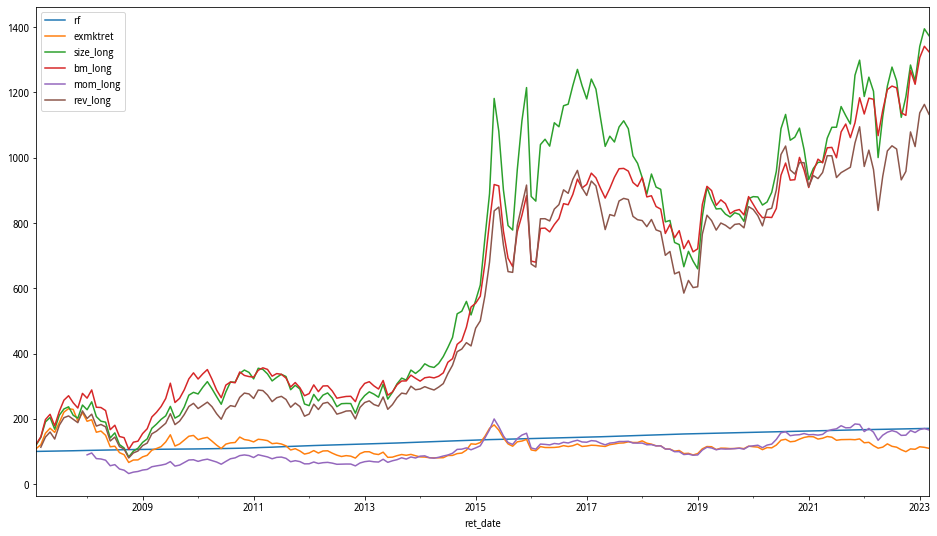

In [49]:
((factors_df+1).cumprod()*100).plot()

In [50]:
factors_df.to_pickle('./output_data/factors/factors_long_only.pkl')

## Long short factors

In [51]:
# factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = factor(df=ret_df,sort1=f,long_only=False,long_high=False)
    else:
        factors_dict[f] = factor(df=ret_df,sort1=f,long_only=False)

In [52]:
factors_df = pd.DataFrame(factors_dict)

In [53]:
# Size
sort1 = 'bm'
portfolios = double_sort(ret_df,sort1=sort1)
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    portfolios[pf]['weighted_ret'] = portfolios[pf]['ret'] * portfolios[pf]['weight']
    portfolios_vwret[pf] = portfolios[pf].groupby('ret_date')['weighted_ret'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[f'{sort1}1_size1'].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_df['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3 - \
      (portfolios_vwret_df['bm1_size2'] + portfolios_vwret_df['bm2_size2'] + portfolios_vwret_df['bm3_size2']) / 3 

In [54]:
factors_df = pd.merge(index_df, factors_df, on='ret_date')
factors_df.set_index('ret_date',inplace=True)
factors_df = factors_df[['rf','exmktret','size','bm','mom','rev']]
factors_df

rf  exmktret      size        bm       mom       rev
ret_date                                                            
2007-02   0.002110  0.089095  0.077335  0.140293       NaN       NaN
2007-03   0.002234  0.108569  0.081013  0.050888       NaN -0.042893
2007-04   0.002125  0.291347  0.037910  0.102383       NaN -0.070701
2007-05   0.002527  0.098653 -0.025365  0.005711       NaN  0.038247
2007-06   0.002542 -0.074613 -0.102133 -0.065699       NaN -0.001760
2007-07   0.002481  0.192378  0.060536  0.056698       NaN  0.124766
2007-08   0.002404  0.167471 -0.073206  0.054124       NaN -0.006058
2007-09   0.002621  0.047576 -0.025461  0.029599       NaN -0.018872
...            ...       ...       ...       ...       ...       ...
2022-08   0.001251 -0.023161 -0.012645  0.045091  0.009880  0.053994
2022-09   0.001426 -0.069726 -0.024745  0.019995  0.032539 -0.023092
2022-10   0.001400 -0.056024  0.096303 -0.013516 -0.014105  0.041520
2022-11   0.001596  0.086455 -0.002378  0.067638  0.019141  0.109737
2022-12   0.001955 -0.010755 -0.021528 -0.017663 -0.019721 -0.028512
2023-01   0.001856  0.071496  0.021835 -0.010379 -0.040733  0.055425
2023-02   0.001910 -0.014827  0.036112  0.023641 -0.004712  0.011633
2023-03   0.001970 -0.026819  0.006368  0.011857 -0.013787 -0.008305

[194 rows x 6 columns]

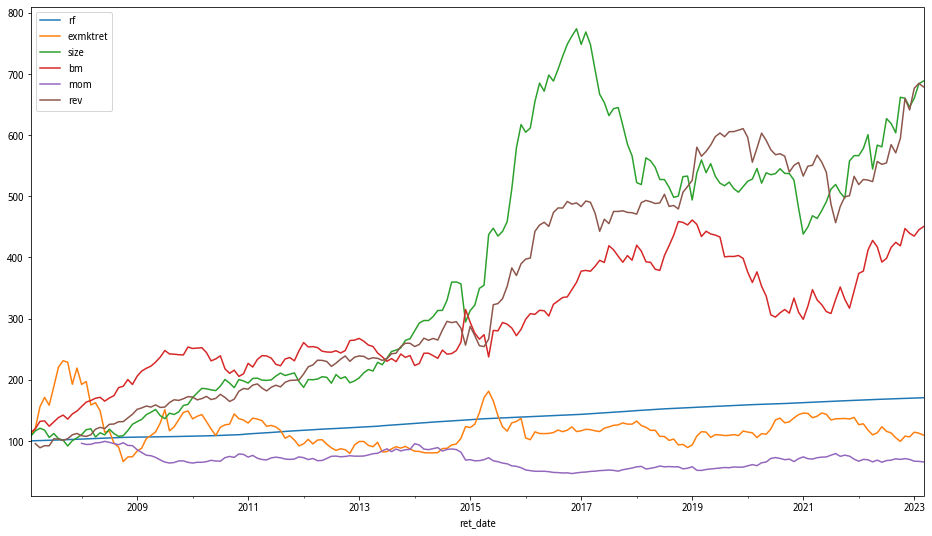

In [55]:
((factors_df+1).cumprod()*100).plot()

In [56]:
factors_df.to_pickle('./output_data/factors/factors.pkl')

# Daily factors

In [57]:
shibor1d = DataAPI.MktIborGet(secID="Shibor1D.IRCN",beginDate=START,endDate=END,field=['tradeDate','rate'],pandas="1")
shibor1d['tradeDate'] = pd.to_datetime(shibor1d['tradeDate'])
shibor1d['rate'] = shibor1d['rate'] * 0.01 / 365
shibor1d.rename(columns={'rate':'rf'},inplace=True)

In [58]:
def daily_factor(df, sort1, sort2='size', long_high=True, long_only=True):
    
    portfolios = double_sort(df=df, sort1=sort1, sort2=sort2)
    portfolios_vwret = {}
    for pf in portfolios.keys():
        temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
        portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
        portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
        df_ = pd.merge(portfolios[pf][['secID','ret_date','weight']],
                       stk_df[['secID','tradeDate','ym','ret_daily']],
                       left_on=['secID','ret_date'],
                       right_on=['secID','ym'])
        df_['weighted_ret_daily'] = df_['ret_daily'] * df_['weight']
        portfolios_vwret[pf] = df_.groupby('tradeDate')['weighted_ret_daily'].sum()

    portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
    portfolios_vwret_df.index = portfolios_vwret[list(portfolios_vwret.keys())[0]].index
    portfolios_vwret_df.columns = portfolios_vwret.keys()
    if long_only:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
    else:
        if long_high:
            factor = (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2
        else:
            factor = (portfolios_vwret_df[f'{sort1}1_{sort2}1'] + portfolios_vwret_df[f'{sort1}1_{sort2}2']) / 2 - \
                     (portfolios_vwret_df[f'{sort1}3_{sort2}1'] + portfolios_vwret_df[f'{sort1}3_{sort2}2']) / 2
    return factor

In [59]:
# Daily factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = daily_factor(df=ret_df,sort1=f,long_high=False)
    else:
        factors_dict[f] = daily_factor(df=ret_df,sort1=f)

In [60]:
factors_daily = pd.DataFrame(factors_dict)

In [61]:
# The size daily factor
portfolios = double_sort(df=ret_df,sort1='bm')
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    df_ = pd.merge(portfolios[pf][['secID','ret_date','weight']],
                   stk_df[['secID','tradeDate','ym','ret_daily']],
                   left_on=['secID','ret_date'],
                   right_on=['secID','ym'])
    df_['weighted_ret_daily'] = df_['ret_daily'] * df_['weight']
    portfolios_vwret[pf] = df_.groupby('tradeDate')['weighted_ret_daily'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[list(portfolios_vwret.keys())[0]].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_daily['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3

In [62]:
factors_daily

bm       mom       rev      size
tradeDate                                         
2007-02-01  0.013241       NaN       NaN  0.009567
2007-02-02 -0.018668       NaN       NaN -0.015228
2007-02-05  0.009517       NaN       NaN  0.015056
2007-02-06  0.028519       NaN       NaN  0.028173
2007-02-07  0.013860       NaN       NaN  0.013953
2007-02-08  0.021072       NaN       NaN  0.017962
2007-02-09 -0.001536       NaN       NaN  0.000616
2007-02-12  0.025930       NaN       NaN  0.023638
...              ...       ...       ...       ...
2023-03-01  0.010064  0.007884  0.008847  0.009576
2023-03-02  0.001421 -0.004647 -0.006972 -0.004121
2023-03-03  0.005110  0.001201  0.001663 -0.001130
2023-03-06 -0.004066  0.002348  0.000525  0.001321
2023-03-07 -0.013322 -0.017141 -0.019231 -0.023023
2023-03-08  0.004463  0.003286  0.002833  0.011766
2023-03-09 -0.000113 -0.002199 -0.000922  0.004052
2023-03-10 -0.015975 -0.016233 -0.012754 -0.013349

[3915 rows x 4 columns]

In [63]:
sec_id = ['000906.ZICN']
index_df = DataAPI.MktIdxdGet(indexID=sec_id,beginDate=START,endDate=END,field=['indexID','secShortName','tradeDate','closeIndex','CHGPct'],pandas="1")
index_df['tradeDate'] = pd.to_datetime(index_df['tradeDate'])

index_df = pd.merge(shibor1d,index_df[['tradeDate','CHGPct']],on='tradeDate')
index_df.rename(columns={'CHGPct':'mktret'},inplace=True)
index_df['exmktret'] = index_df['mktret'] - index_df['rf']

In [64]:
index_df

tradeDate        rf    mktret  exmktret
0    2007-01-04  0.000039  0.009605  0.009566
1    2007-01-05  0.000038  0.008121  0.008083
2    2007-01-08  0.000038  0.032249  0.032211
3    2007-01-09  0.000037  0.029767  0.029730
4    2007-01-10  0.000037  0.025520  0.025483
5    2007-01-11  0.000037 -0.007034 -0.007071
6    2007-01-12  0.000036 -0.028233 -0.028269
7    2007-01-15  0.000036  0.053024  0.052988
...         ...       ...       ...       ...
3927 2023-03-01  0.000057  0.012275  0.012218
3928 2023-03-02  0.000044 -0.002458 -0.002502
3929 2023-03-03  0.000035  0.002634  0.002599
3930 2023-03-06  0.000034 -0.003669 -0.003703
3931 2023-03-07  0.000039 -0.015342 -0.015381
3932 2023-03-08  0.000045 -0.001989 -0.002034
3933 2023-03-09  0.000038 -0.003257 -0.003295
3934 2023-03-10  0.000050 -0.013057 -0.013107

[3935 rows x 4 columns]

In [65]:
factors_daily = pd.merge(index_df[['tradeDate','rf','exmktret']],factors_daily, on='tradeDate')

factors_daily.set_index('tradeDate',inplace=True)

factors_daily = factors_daily[['rf','exmktret','size','bm','mom','rev']]

In [66]:
factors_daily.columns = ['rf','exmktret','size_long','bm_long','mom_long','rev_long']

In [67]:
factors_daily

rf  exmktret  size_long   bm_long  mom_long  rev_long
tradeDate                                                              
2007-02-01  0.000048  0.005542   0.009567  0.013241       NaN       NaN
2007-02-02  0.000048 -0.035335  -0.015228 -0.018668       NaN       NaN
2007-02-05  0.000048 -0.005993   0.015056  0.009517       NaN       NaN
2007-02-06  0.000049  0.019879   0.028173  0.028519       NaN       NaN
2007-02-07  0.000050  0.021923   0.013953  0.013860       NaN       NaN
2007-02-08  0.000052  0.017380   0.017962  0.021072       NaN       NaN
2007-02-09  0.000076 -0.003355   0.000616 -0.001536       NaN       NaN
2007-02-12  0.000110  0.033455   0.023638  0.025930       NaN       NaN
...              ...       ...        ...       ...       ...       ...
2023-03-01  0.000057  0.012218   0.009576  0.010064  0.007884  0.008847
2023-03-02  0.000044 -0.002502  -0.004121  0.001421 -0.004647 -0.006972
2023-03-03  0.000035  0.002599  -0.001130  0.005110  0.001201  0.001663
2023-03-06  0.000034 -0.003703   0.001321 -0.004066  0.002348  0.000525
2023-03-07  0.000039 -0.015381  -0.023023 -0.013322 -0.017141 -0.019231
2023-03-08  0.000045 -0.002034   0.011766  0.004463  0.003286  0.002833
2023-03-09  0.000038 -0.003295   0.004052 -0.000113 -0.002199 -0.000922
2023-03-10  0.000050 -0.013107  -0.013349 -0.015975 -0.016233 -0.012754

[3915 rows x 6 columns]

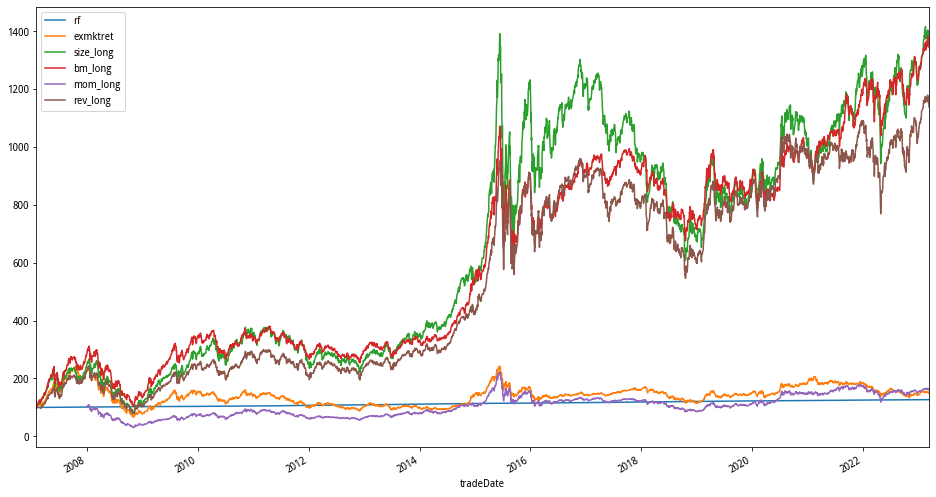

In [68]:
((factors_daily+1).cumprod()*100).plot()

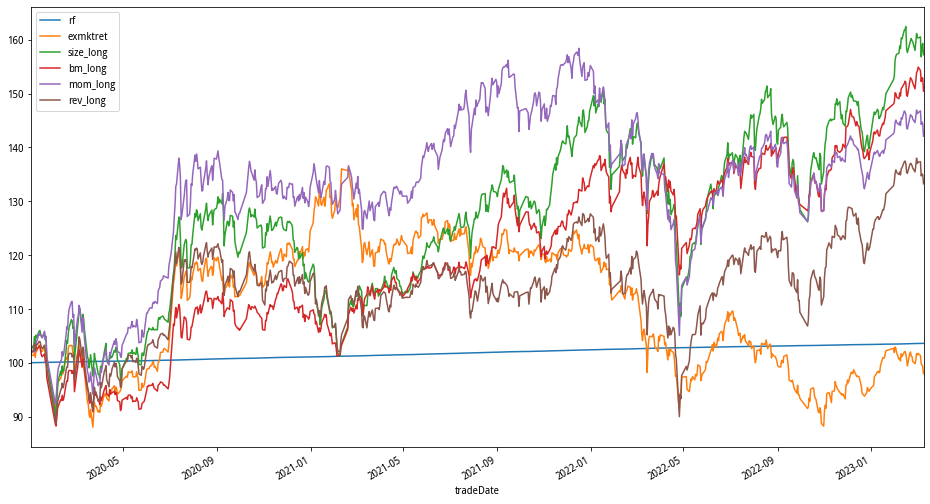

In [69]:
((factors_daily.loc['2020':]+1).cumprod()*100).plot()

In [70]:
factors_daily.to_pickle('./output_data/factors/factors_daily_long_only.pkl')

## Long short factors

In [71]:
# Daily factors excluding size
factors_dict = {}
for f in ['bm','mom','rev']:
    if f == 'rev':
        factors_dict[f] = daily_factor(df=ret_df,sort1=f,long_only=False,long_high=False)
    else:
        factors_dict[f] = daily_factor(df=ret_df,sort1=f,long_only=False)

In [72]:
factors_daily = pd.DataFrame(factors_dict)

In [73]:
# The size daily factor
portfolios = double_sort(df=ret_df,sort1='bm')
portfolios_vwret = {}
for pf in portfolios.keys():
    temp = portfolios[pf].groupby('ym')['mktcap'].agg({'mktcap_sum':np.sum})
    portfolios[pf] = pd.merge(portfolios[pf], temp, on='ym')
    portfolios[pf]['weight'] = portfolios[pf]['mktcap'] / portfolios[pf]['mktcap_sum']
    df_ = pd.merge(portfolios[pf][['secID','ret_date','weight']],
                   stk_df[['secID','tradeDate','ym','ret_daily']],
                   left_on=['secID','ret_date'],
                   right_on=['secID','ym'])
    df_['weighted_ret_daily'] = df_['ret_daily'] * df_['weight']
    portfolios_vwret[pf] = df_.groupby('tradeDate')['weighted_ret_daily'].sum()

portfolios_vwret_df = pd.DataFrame(np.vstack([pf for pf in portfolios_vwret.values()])).T
portfolios_vwret_df.index = portfolios_vwret[list(portfolios_vwret.keys())[0]].index
portfolios_vwret_df.columns = portfolios_vwret.keys()

factors_daily['size'] = (portfolios_vwret_df['bm1_size1'] + portfolios_vwret_df['bm2_size1'] + portfolios_vwret_df['bm3_size1']) / 3 - \
      (portfolios_vwret_df['bm1_size2'] + portfolios_vwret_df['bm2_size2'] + portfolios_vwret_df['bm3_size2']) / 3 

In [74]:
factors_daily

bm       mom       rev      size
tradeDate                                         
2007-02-01  0.007141       NaN       NaN  0.002193
2007-02-02  0.010887       NaN       NaN  0.018346
2007-02-05  0.009071       NaN       NaN  0.019852
2007-02-06  0.005678       NaN       NaN  0.006771
2007-02-07 -0.004263       NaN       NaN -0.007161
2007-02-08  0.004951       NaN       NaN -0.000822
2007-02-09  0.001221       NaN       NaN  0.003797
2007-02-12 -0.005880       NaN       NaN -0.009410
...              ...       ...       ...       ...
2023-03-01  0.002296 -0.005329 -0.003995 -0.001004
2023-03-02  0.008971 -0.002233 -0.006793 -0.002209
2023-03-03  0.006088  0.001806  0.004329 -0.004169
2023-03-06 -0.007538  0.004599  0.000788  0.003056
2023-03-07  0.007773  0.005362  0.003633 -0.008653
2023-03-08 -0.000479 -0.007435 -0.006697  0.012430
2023-03-09  0.000205 -0.007228 -0.001795  0.006774
2023-03-10 -0.005310 -0.003413  0.002104  0.000548

[3915 rows x 4 columns]

In [75]:
factors_daily = pd.merge(index_df[['tradeDate','rf','exmktret']],factors_daily, on='tradeDate')

factors_daily.set_index('tradeDate',inplace=True)

factors_daily = factors_daily[['rf','exmktret','size','bm','mom','rev']]

In [76]:
factors_daily

rf  exmktret      size        bm       mom       rev
tradeDate                                                             
2007-02-01  0.000048  0.005542  0.002193  0.007141       NaN       NaN
2007-02-02  0.000048 -0.035335  0.018346  0.010887       NaN       NaN
2007-02-05  0.000048 -0.005993  0.019852  0.009071       NaN       NaN
2007-02-06  0.000049  0.019879  0.006771  0.005678       NaN       NaN
2007-02-07  0.000050  0.021923 -0.007161 -0.004263       NaN       NaN
2007-02-08  0.000052  0.017380 -0.000822  0.004951       NaN       NaN
2007-02-09  0.000076 -0.003355  0.003797  0.001221       NaN       NaN
2007-02-12  0.000110  0.033455 -0.009410 -0.005880       NaN       NaN
...              ...       ...       ...       ...       ...       ...
2023-03-01  0.000057  0.012218 -0.001004  0.002296 -0.005329 -0.003995
2023-03-02  0.000044 -0.002502 -0.002209  0.008971 -0.002233 -0.006793
2023-03-03  0.000035  0.002599 -0.004169  0.006088  0.001806  0.004329
2023-03-06  0.000034 -0.003703  0.003056 -0.007538  0.004599  0.000788
2023-03-07  0.000039 -0.015381 -0.008653  0.007773  0.005362  0.003633
2023-03-08  0.000045 -0.002034  0.012430 -0.000479 -0.007435 -0.006697
2023-03-09  0.000038 -0.003295  0.006774  0.000205 -0.007228 -0.001795
2023-03-10  0.000050 -0.013107  0.000548 -0.005310 -0.003413  0.002104

[3915 rows x 6 columns]

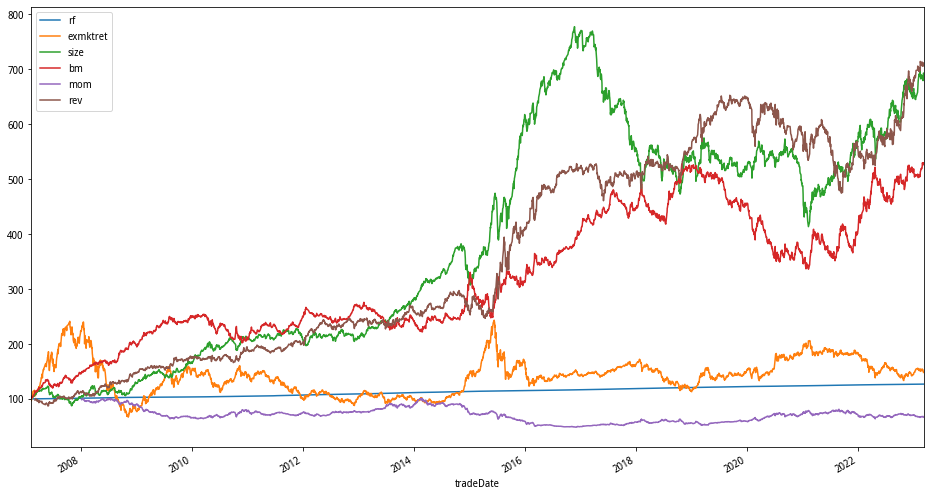

In [77]:
((factors_daily+1).cumprod()*100).plot()

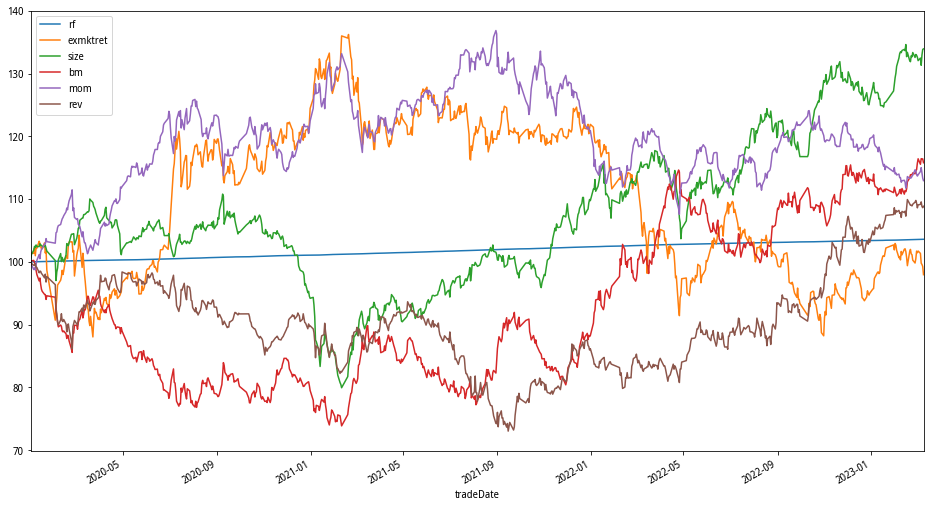

In [78]:
((factors_daily.loc['2020':]+1).cumprod()*100).plot()

In [79]:
factors_daily.to_pickle('./output_data/factors/factors_daily.pkl')